In [1]:
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

## Plotting the NCMC acceptance rate for HIP in explicit solvent

Seeing how the number of NCMC perturbations affects the acceptance rate of HIP (the AMBER name for fully protonated histidine) for constant-pH simulations with `protons`.

The list below shows the number of NCMC perturbation steps that were used. Each perturbation step is followed by 1fs of dynamics. For example, 10000 perturbation steps means that the simulation time for NCMC protocol is 10ps.

In [2]:
nperts = [0, 100, 1000, 5000, 10000, 20000, 30000, 50000, 75000]

In this notebook, the data reported is from 500 iterations of molecular dynamics and `protons` steps. A single iteration consisted of 500 steps of MD (with a 2fs timestep) and 1 proton insertion deletion attempt using NCMC.

## Estimating the acceptance rate of instantaneous moves
When no `protons` moves have been accepted, one can still estimate the acceptance probability, denoted $\hat{A}$, by looking at the protocol work $w_i$, which is multiples of $k_B T$.

$$ \hat{A} = \frac{1}{N} \sum_{i=1}^{N} \text{min} \left\{1, e^{-(w_i - g_k)} \right\} \\ \approx  \frac{1}{N} \sum_{i=1}^{N} e^{-(w_i - g_k)} $$

when $e^{-(w - g_k)} \ll 1$, which is the case for, say, instantaneous `protons` moves. Above, $g_k$ denotes the protonation state weight.

### Loading the data
Using multiple repeats where available.

In [156]:
def read_work(filename):
    """
    Read and output the work for a protons NCMC attempts.
    """
    lines = open(filename,'r').readlines()
    energy = []
    for line in lines:
        wrk = float(line.split('\n')[0])
        # Removing proposals to same state
        if wrk != 0.0:
            energy.append(wrk)
    return np.array(energy)

In [165]:
# Reading the simulation data
accprob_mean = []      # where the acceptance will be stored
accprob_sd = []
log_accprob_sd = []

for p in nperts:
    a = []
    for repeat in ('out', 'out1', 'out2', 'out3', 'out4', 'out5'):
        try:
            filename = str(p) + '_ncmc_steps/' + repeat + '.txt'
            lines = open(filename,'r').readlines()
            a.append(float(lines[-1].split()[2]))
        except IOError:
            pass
    a = np.array(a)
    if a.mean() == 0.0:
        print('Zero accepted for npert = {}'.format(p))
        filename = str(p) + '_ncmc_steps/out5_work.txt'
        energy = read_work(filename)
        if p == 0:
            energy = np.hstack((energy,read_work('0_ncmc_steps/out4_work.txt')))
        prob = np.exp(-energy)
        accprob_mean.append(prob.mean())
        accprob_sd.append(prob.std())
        log_accprob_sd.append(std_log10(prob))
    else:
        accprob_mean.append(a.mean())
        accprob_sd.append(a.std())


Zero accepted for npert = 0
Zero accepted for npert = 100


## Plotting
**Acceptance rates**:

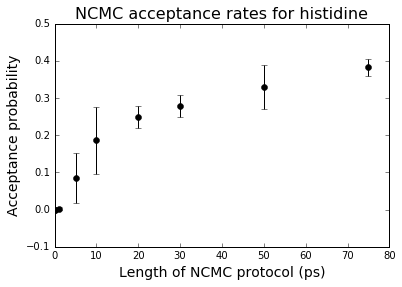

In [166]:
ncmc_time = np.array(nperts)/1000.0   # The length of the NCMC protocol in ps.
plt.errorbar(ncmc_time, accprob_mean, yerr=accprob_sd, fmt='o', color='k')
plt.title('NCMC acceptance rates for histidine', fontsize=16)
plt.xlabel('Length of NCMC protocol (ps)', fontsize=14)
plt.ylabel('Acceptance probability', fontsize=14)
plt.show()

**Log of the acceptance rates**:

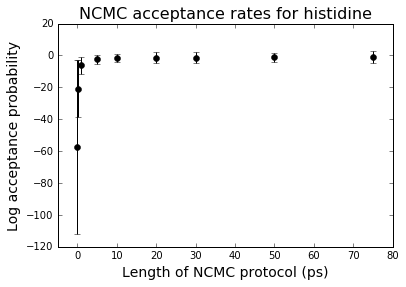

In [167]:
ncmc_time = np.array(nperts)/1000.0   # The length of the NCMC protocol in ps.
plt.errorbar(ncmc_time, np.log(accprob_mean), yerr=np.log(accprob_sd), fmt='o', color='k')
plt.title('NCMC acceptance rates for histidine', fontsize=16)
plt.xlabel('Length of NCMC protocol (ps)', fontsize=14)
plt.ylabel('Log acceptance probability', fontsize=14)
plt.xlim((-5,80))
#plt.xlim((-0,5,ncmc_time[-1]+0,5))
plt.show()

**Combining both into a single image**

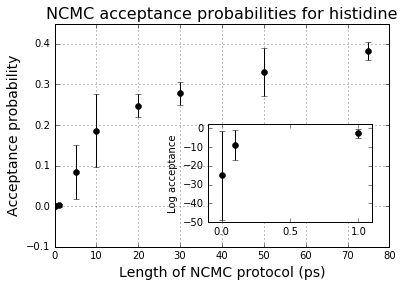

In [179]:
ncmc_time = np.array(nperts)/1000.0   # The length of the NCMC protocol in ps.

plt.errorbar(ncmc_time, accprob_mean, yerr=accprob_sd, fmt='o', color='k')
plt.title('NCMC acceptance probabilities for histidine', fontsize=16)
plt.xlabel('Length of NCMC protocol (ps)', fontsize=14)
plt.ylabel('Acceptance probability', fontsize=14)
plt.ylim((-0.1,0.45))
plt.grid()

inset = plt.axes([0.48,0.21,0.38,0.34]) 

log10_ncmc_time = np.hstack((-5,np.log10(ncmc_time[1:3])))     # Avoiding the nan at ncmc_time=0
#plt.errorbar(log10_ncmc_time, np.log10(accprob_mean[0:3]), yerr=np.log10(accprob_sd[0:3]), fmt='o', color='k')
plt.errorbar(ncmc_time[0:3], np.log10(accprob_mean[0:3]), yerr=np.log10(accprob_sd[0:3]), fmt='o', color='k')
plt.xlim((-0.1,1.1))
plt.ylim((-50,2))
plt.xticks((0,0.5,1.0))
plt.ylabel('Log acceptance')
plt.ylabel('Log acceptance')
plt.savefig('HIS_acceptance.png',format='png', dpi=100)
plt.show()
